# Implementation using Linear - FAILED
#### MASK calculation in SegmentNet is the main value. it is not simple argmax. 


* The difference between SegmentNet and Linear is that in SegmentNet only one Segment predicts y while others are masked out but in Linear every neuron predicts y and the net y is a sum of all.
* I think if we replace sum with value from the only one neuron we may achieve segmentNet. 
* Experiment with value that is farthest away from 0
* abs_values = np.abs(tensor); farthest_index = np.argmax(abs_values); farthest_value = tensor[farthest_index]


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

# Define Model

In [45]:
class LinearSegment(nn.Module):
    __constants__ = ['in_features', 'out_features', 'segment_features']
    in_features: int
    out_features: int
    segment_features: int
    def __init__(self, segment_features, in_features=1, out_features=1):
        super(LinearSegment, self).__init__()
        self.segment_features = segment_features
        self.out_features = out_features
        self.in_features = in_features

        self.l1 = nn.Linear(in_features, segment_features)

    def mask(self, x):
        abs_value = torch.abs(x)
        farthest_index = torch.argmax(abs_value, dim=1)
        farthest_value = x[np.arange(x.shape[0]), farthest_index]
        return farthest_value
    
    def forward(self, x):
        y1 = self.l1(x)
        y = self.mask(y1)
        return y

# Create Test Dataset

In [4]:
def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def normalize(x,y):
    x_normalized = torch.nn.functional.normalize(x, dim=0)
    y_normalized = torch.nn.functional.normalize(y, dim=0)
    return x_normalized, y_normalized

In [5]:
x_in = torch.arange(-1.5, 11., .05)
ytest = f_quartic(x_in)
#normalization - important
x_in, ytest = normalize(x_in, ytest)
print(x_in.shape, ytest.shape)

# Reshape x, ytest to N,1
x_in = x_in.view(x_in.shape[0], 1)
ytest = ytest.reshape(x_in.shape[0], 1)
print(x_in.shape, ytest.shape)

torch.Size([250]) torch.Size([250])
torch.Size([250, 1]) torch.Size([250, 1])


# Model Init

In [57]:
torch.manual_seed(10)

segments = 4
model = LinearSegment(segments, x_in.shape[1], ytest.shape[1])

#Initialize model parameters - extremely important.
#model.custom_init(x_in.min(dim=0).values, x_in.max(dim=0).values)

criterion = nn.MSELoss(reduction='sum')

lr=.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x_in, ytest)
batch_size=64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## Training Loop

In [58]:
num_epochs = 20000
losses = np.array([])
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # Forward pass
        [X, Y] = data
        ypred = model(X)
        # Calculate the loss
        loss = criterion(ypred, Y)
        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if epoch % (num_epochs/10) == 0:
        losses = np.append(losses, train_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss))

====> Epoch: 2000 Average loss: 20.9134
====> Epoch: 4000 Average loss: 20.8931
====> Epoch: 6000 Average loss: 20.9791
====> Epoch: 8000 Average loss: 20.8542
====> Epoch: 10000 Average loss: 20.8915
====> Epoch: 12000 Average loss: 20.9476
====> Epoch: 14000 Average loss: 20.8764
====> Epoch: 16000 Average loss: 20.8812


KeyboardInterrupt: 

last total_mean_loss  20.913398265838623


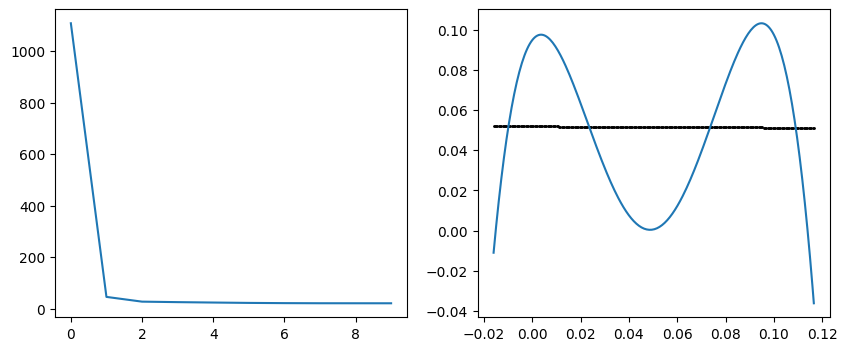

In [52]:
# plot graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print ("last total_mean_loss ",train_loss)
ax1.plot(losses)

# plot trained model
y = model(x_in)
y = y.detach().numpy()
ax2.plot(x_in, ytest)
ax2.scatter(x_in, y, color='black', s=1)

# Display the plot
plt.show()

In [29]:
y.shape

(250, 250)

# Plot model parameters

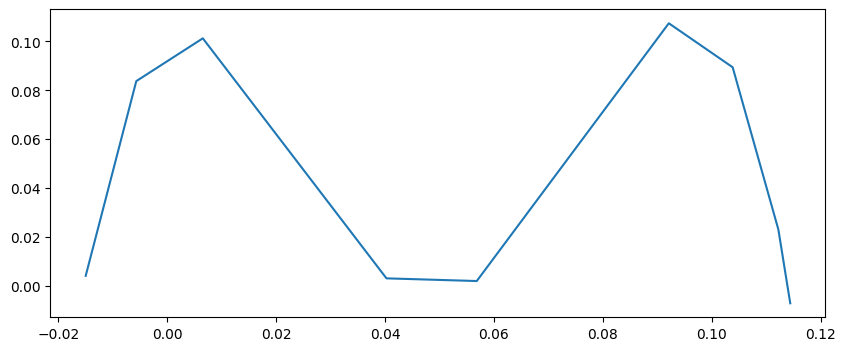

In [67]:
xval = model.x.reshape(model.x.shape[1]).detach().numpy()
yval = model.y.reshape(model.x.shape[1]).detach().numpy()
plt.plot(xval,yval) 
plt.show()

In [61]:
model.x.reshape(model.x.shape[1]),model.y.reshape(model.x.shape[1])

(tensor([-0.0150, -0.0055,  0.0070,  0.0401,  0.0562,  0.0954,  0.1088,  0.1129,
          0.1145], grad_fn=<ViewBackward0>),
 tensor([ 0.0044,  0.0852,  0.1005,  0.0034,  0.0014,  0.1140,  0.0582,  0.0117,
         -0.0095], grad_fn=<ViewBackward0>))